In [1]:
import math
import time

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import optax 

from typing import Sequence, Callable

import equinox as eqx

In [2]:
class FNN(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, width_size, depth, *, key):
        self.mlp = eqx.nn.MLP(
            in_size, out_size, width_size=width_size, depth=depth, key=key
        )

    def __call__(self, t, x, train: bool = True):
        y, f_vjp = jax.vjp(lambda x: self.mlp(jnp.concatenate([t, x])), x)
        dudx = f_vjp(jnp.ones(y.shape))
        return y, dudx[0]

In [3]:
class FBSDECell(eqx.Module):
    u_module: eqx.Module
    dt: float
    mu_fn: Callable = eqx.static_field()
    sigma_fn: Callable = eqx.static_field()
    phi_fn: Callable = eqx.static_field()

    def __init__(self, unet, dt, in_size, out_size, width_size, depth, key):
        self.u_module = unet(in_size=in_size, out_size=1, width_size=16, depth=4, key=key)
        def mu_fn(t, X, Y, Z):
            del t, Y, Z
            return jnp.zeros_like(X)

        def sigma_fn(t, X, Y):
            del t, Y
            return 0.4 * X

        def phi_fn(t, X, Y, Z):
            del t
            return 0.05 * (Y - jnp.sum(X * Z, keepdims=True))
        
        self.mu_fn = mu_fn
        self.sigma_fn = sigma_fn
        self.phi_fn = phi_fn
        
        self.dt = dt

    def u_and_dudx(self, t, x):
        return self.u_module(t, x)

    def __call__(self, carry, dW):
        # `t` and `W` are (batch_size, num_timestep, dim)
        # it have input data across iterations 
        i, x0, y0, z0 = carry

        # use `i` to index input data
        t0 = jnp.full((1, ), i * self.dt)
        t1 = jnp.full((1, ), (i + 1) * self.dt)

        x1 = x0 + self.mu_fn(t0, x0, y0, z0) * self.dt + \
                self.sigma_fn(t0, x0, y0) * dW
        
        y1_tilde = y0 + self.phi_fn(t0, x0, y0, z0) * self.dt + \
            jnp.sum(z0 * self.sigma_fn(t0, x0, y0) * dW, keepdims=True)
        
        y1, z1 = self.u_module(t1, x1)

        carry = (i+1, x1, y1, z1)
        outputs = (x1, y1_tilde, y1)
        return carry, outputs

In [13]:
class FBSDE(eqx.Module):
    # u_net: ModuleDef
    step_cell: eqx.Module
    # equ_problem: Any
    
    def __init__(self, step_cell_module, u_and_du_module, dt, in_size, out_size, width_size, depth, key):
        self.step_cell = step_cell_module(u_and_du_module, dt, in_size, out_size, width_size, depth, key)

    def __call__(self, x0, W, unroll=1):
        
        y0, z0 = self.step_cell.u_and_dudx(t=jnp.zeros((1, )), x=x0)

        carry = (0, x0, y0, z0)

        def f(carry, input):
            return self.step_cell(carry, input)

        # for i in range(10):
        #     carry, output = f(carry, W[i])
        (carry, output) = jax.lax.scan(f, carry, W, unroll=unroll)
        return (carry, output)

In [39]:
batch_size = 24
dim = 100
num_timesteps = 50

@jax.jit
def sum_square_error(y, y_pred):
    """Computes the sum of square error."""
    return jnp.sum(jnp.square(y - y_pred))

def fetch_minibatch(rng):  # Generate time + a Brownian motion
    T = 1.0
    M = batch_size
    N = num_timesteps
    D = dim

    dt = T / N * jnp.ones((M, 1))
    dW = jnp.sqrt(T / N) * jrandom.normal(rng, shape=(M, N, D))

    return dt, dW

In [40]:
def g_fn(X):
    return jnp.sum(X ** 2, axis=-1, keepdims=True)

def dg_fn(X):
    y, vjp_func = jax.vjp(g_fn, X)
    return vjp_func(jnp.ones(y.shape))[0]

@eqx.filter_jit
def train_step(model, x0, data, opt_state, optim, unroll=1):
    # batch_size = model.batch_size
    t, W = data

    def loss_fn(model, W):
        loss = 0.0
        
        out_carry, out_val = jax.vmap(model, in_axes=(0, 0, None))(x0, W, unroll)
        
    
        (_, x_final, y_final, z_final) = out_carry
        (x, y_tilde_list, y_list) = out_val
        

        loss += sum_square_error(y_tilde_list, y_list)
        loss += sum_square_error(y_final, g_fn(x_final))
        loss += sum_square_error(z_final, dg_fn(x_final))

        return (loss, y_list)

    # loss = loss_fn(model, W)
    (loss, y), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, W)
    
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return loss, model, opt_state, y

start_time = time.time()
iter_time_list = []

learning_rate = 1e-3
rng = jrandom.PRNGKey(0)

model = FBSDE(FBSDECell, FNN, 0.1, in_size=dim + 1, out_size=1, width_size=16, depth=4, key=rng)

x0 = jnp.array([[1.0, 0.5] * int(dim / 2)])
x0 = jnp.broadcast_to(x0, (batch_size, dim))


optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

unroll = 1
verbose = True
num_iters = 5000


for i in range(num_iters):
    rng, _ = jax.random.split(rng)
    data = fetch_minibatch(rng)
    loss, model, loss, y_pred = train_step(model, x0, data, opt_state, optim, unroll)

    if verbose:
        if i == 0:
            compile_time = time.time()
            iter_time = time.time()
        if i % 100 == 0 and i > 0:
            print(f"y: {y_pred[0, 0, 0]}")

if verbose:
    # output = output + str(num_iters) + ","
    # output = output + str(np.mean(iter_time_list)) + ","
    print(f"compile: {compile_time - start_time}")
    print(f"run: {time.time() - compile_time}")
    # output = output + str(compile_time - start_time) + ','
    # output = output + str(time.time() - compile_time)

    # print(f"num_iteration: {num_iters}")
    # print(f"unroll: {unroll}")
    # print(f"batch_size: {batch_size}")
    # print(f"total_time: {time.time() - start_time}")
    # print(f"iter100_time: {np.mean(iter_time_list)}")
    # print(f"compile_time: {(compile_time - start_time)}")

y: 17.099023818969727
y: 70.8621826171875
y: 71.46733093261719
y: 69.95726013183594
y: 73.62258911132812
y: 75.76731872558594
y: 76.79094696044922
y: 78.21385955810547
y: 80.69690704345703
y: 82.58635711669922
y: 84.5090103149414
y: 89.42118835449219
y: 89.26970672607422
y: 92.23274993896484
y: 95.53018188476562
y: 94.58561706542969
y: 93.58668518066406
y: 96.21033477783203
y: 98.47735595703125
y: 98.39154052734375
y: 95.16387939453125
y: 98.02447509765625
y: 101.03229522705078
y: 98.35292053222656
y: 99.20654296875
y: 97.9238052368164
y: 98.4158706665039
y: 98.55155944824219
y: 98.62186431884766
y: 96.88565826416016
y: 97.45145416259766
y: 95.79957580566406
y: 96.60130310058594
y: 99.20453643798828
y: 98.92669677734375
y: 97.04324340820312
y: 99.6142807006836
y: 95.87039184570312
y: 97.74238586425781
y: 95.97278594970703
y: 95.84075164794922
y: 94.66751098632812
y: 96.32112884521484
y: 96.2701187133789
y: 99.07133483886719
y: 94.70353698730469
y: 96.80362701416016
y: 97.6423110961914


(24, 50, 1)


ValueError: x and y must have same first dimension, but have shapes (51, 4) and (50, 4)

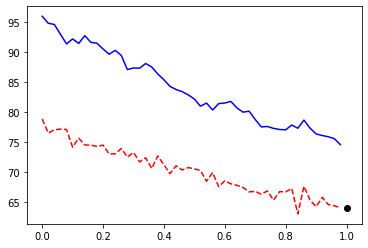

In [55]:
import matplotlib.pyplot as plt

def u_exact(t, X): # (N+1) x 1, (N+1) x D
    r = 0.05
    sigma_max = 0.4
    return jnp.exp((r + sigma_max**2)*(1.0 - t))*jnp.sum(X**2, 1, keepdims = True)

samples = fetch_minibatch(rng)
_, W_test = samples

Dt = jnp.concatenate([jnp.zeros((batch_size, 1), dtype=jnp.float32), jnp.ones((batch_size, num_timesteps)) * 1.0 / num_timesteps], axis=1).reshape((batch_size, num_timesteps+1, 1))
t_test = jnp.cumsum(Dt, axis=1)  # M x (N+1) x 1

_, (X_pred, y_tilde_list, Y_pred) = out_carry, out_val = jax.vmap(model, in_axes=(0, 0, None))(x0, W_test, unroll)

X_pred = jnp.transpose(X_pred, (1, 0, 2))
# Y_pred = jnp.transpose(Y_pred, (1, 0, 2))

print(Y_pred.shape)
Y_test = jnp.reshape(u_exact(jnp.reshape(t_test[0:batch_size, 0:num_timesteps,:],[-1,1]), jnp.reshape(X_pred,[-1,dim])),[batch_size,-1,1])

n_samples = 5
    
plt.figure()
plt.plot(t_test[0:1,:-1,0].T,Y_pred[0:1,:,0].T,'b',label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1,:-1,0].T,Y_test[0:1,:,0].T,'r--',label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0],Y_test[0:1,-1,0],'ko',label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:n_samples,:,0].T,Y_pred[1:n_samples,:,0].T,'b')
plt.plot(t_test[1:n_samples,:,0].T,Y_test[1:n_samples,:,0].T,'r--')
plt.plot(t_test[1:n_samples,-1,0],Y_test[1:n_samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

In [ ]:
# from functools import partial


# t = jnp.ones((batch_size, 1))
# x = jnp.ones((batch_size, dim))

# key = jrandom.PRNGKey(0)
# u_net = FNN(in_size=dim + 1, out_size=1, width_size=16, depth=4, key=key)
# y = jax.vmap(u_net)(t, x)

# cell = FBSDECell(FNN, 0.1, in_size=dim + 1, out_size=1, width_size=16, depth=4, key=key)
# y_cell = jax.vmap(cell.u_and_dudx)(t, x)

# fbsde = FBSDE(FBSDECell, FNN, 0.1, in_size=dim + 1, out_size=1, width_size=16, depth=4, key=key)

# x0 = jnp.array([[1.0, 0.5] * int(dim / 2)])
# x0 = jnp.broadcast_to(x0, (batch_size, dim))
# dW = jnp.sqrt(1.0 / 10) * jrandom.normal(key, shape=(batch_size, 10, dim))


# ys = jax.vmap(fbsde)(x0, dW)



(DeviceArray([[[1.1746974 , 0.42982185, 0.9406653 , 0.61951697],
              [1.2481725 , 0.465357  , 1.1100757 , 0.62369955],
              [1.1550037 , 0.43282104, 1.0471375 , 0.66332424],
              [0.97279197, 0.42727527, 1.0839267 , 0.70177275],
              [0.9238278 , 0.4878743 , 0.9180831 , 0.73923206],
              [0.9229359 , 0.5574749 , 0.7945976 , 0.730662  ],
              [0.9734122 , 0.69411224, 0.78127503, 0.7408416 ],
              [0.7458365 , 0.5151861 , 0.7411844 , 0.64962894],
              [0.7504046 , 0.54768604, 0.81503123, 0.53946143],
              [0.74877596, 0.60970867, 0.6960704 , 0.6772267 ]],

             [[1.1540112 , 0.47929046, 1.0963778 , 0.47691432],
              [1.3925209 , 0.5191048 , 1.2999451 , 0.4107818 ],
              [1.2712698 , 0.4787723 , 1.4412907 , 0.43529066],
              [1.0465666 , 0.47557282, 1.4635291 , 0.5318118 ],
              [1.0121542 , 0.38431183, 1.0862967 , 0.49355495],
              [1.0988384 , 0.4421987 